In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
import json
labels_map = json.load(open("label_maps.json"))


In [3]:
class FlowerCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(FlowerCNN, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        # Calculate the input size for the fully connected layer
        fc1_input_size = self._get_fc1_input_size()

        self.fc1 = nn.Linear(fc1_input_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.6)

    def _get_fc1_input_size(self):
        dummy_input = torch.zeros(1, 3, 224, 224)
        output = self._forward_features(dummy_input)
        return output.view(-1).shape[0]

    def _forward_features(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.max_pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.max_pool(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.bn4(x)
        x = self.max_pool(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.bn5(x)
        x = self.max_pool(x)

        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [4]:
'''
34% accuracy
learning_rate = 0.0001 # 0.0001 = 41.5% accuracy
batch_size = 16
num_epochs = 50
momentum = 0.9
weight_decay = 1e-4

35.4
learning_rate = 0.0001 # 0.0001 = 41.5% accuracy
batch_size = 16
num_epochs = 50
momentum = 0.9
weight_decay = 1e-3#

learning_rate = 0.0001 # 0.0001 = 41.5% accuracy
batch_size = 8
num_epochs = 50
momentum = 0.9
weight_decay = 1e-3

36.5
learning_rate = 0.00008 # 0.0001 = 41.5% accuracy
batch_size = 8
num_epochs = 50
momentum = 0.9
weight_decay = 1e-3

'''

'\n34% accuracy\nlearning_rate = 0.0001 # 0.0001 = 41.5% accuracy\nbatch_size = 16\nnum_epochs = 50\nmomentum = 0.9\nweight_decay = 1e-4\n\n35.4\nlearning_rate = 0.0001 # 0.0001 = 41.5% accuracy\nbatch_size = 16\nnum_epochs = 50\nmomentum = 0.9\nweight_decay = 1e-3#\n\nlearning_rate = 0.0001 # 0.0001 = 41.5% accuracy\nbatch_size = 8\nnum_epochs = 50\nmomentum = 0.9\nweight_decay = 1e-3\n\n36.5\nlearning_rate = 0.00008 # 0.0001 = 41.5% accuracy\nbatch_size = 8\nnum_epochs = 50\nmomentum = 0.9\nweight_decay = 1e-3\n\n'

In [5]:
# HYPERPARAMETERS
learning_rate = 0.0001 # 0.0001 = 41.5% accuracy
batch_size = 16
num_epochs = 100
momentum = 0.7
weight_decay = 1e-3


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
import torchvision
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform2 = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

transform3 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load dataset

train_set = torchvision.datasets.Flowers102(root="data", download=True, transform=transform)
train_set2 = torchvision.datasets.Flowers102(root="data", download=True, transform=transform2)
train_set3 = torchvision.datasets.Flowers102(root="data", download=True, transform=transform3)
test_set = torchvision.datasets.Flowers102(root="data", download=True, split="test", transform=transform)
val_set = torchvision.datasets.Flowers102(root="data", download=True, split="val", transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)
train_loader3 = DataLoader(train_set3, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
print(len(train_set), len(test_set), len(val_set))


1020 6149 1020


In [7]:
def merge_loaders(*loaders):
    for loader in loaders:
        for data in loader:
            yield data

merged_train_loader = merge_loaders(train_loader, train_loader3)


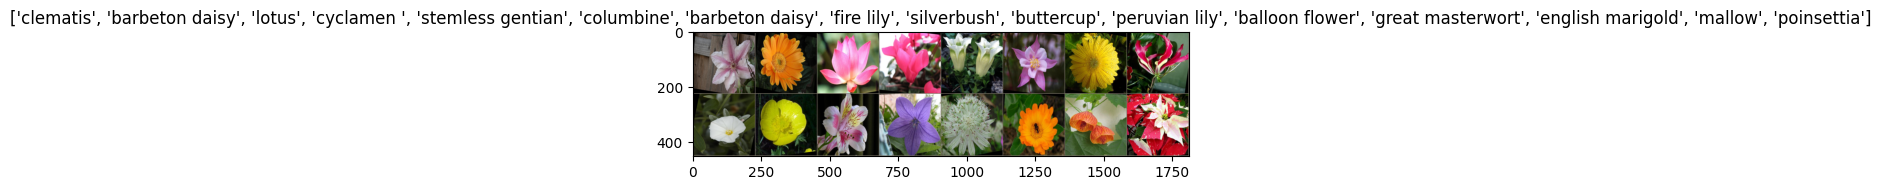

In [8]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()
dataiter = iter(merged_train_loader)
images, labels = dataiter.__next__()

# Create a grid of images and display them along with their labels
grid = torchvision.utils.make_grid(images)
title = [labels_map[str(label.item())] for label in labels]
imshow(grid, title)

In [9]:
model = FlowerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [10]:
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(merged_train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%")

# Testing loop


Epoch [1/100], Validation Accuracy: 1.86%
Epoch [2/100], Validation Accuracy: 1.96%
Epoch [3/100], Validation Accuracy: 2.55%
Epoch [4/100], Validation Accuracy: 1.67%
Epoch [5/100], Validation Accuracy: 1.96%
Epoch [6/100], Validation Accuracy: 3.04%
Epoch [7/100], Validation Accuracy: 1.86%
Epoch [8/100], Validation Accuracy: 2.25%
Epoch [9/100], Validation Accuracy: 1.67%
Epoch [10/100], Validation Accuracy: 2.16%
Epoch [11/100], Validation Accuracy: 2.16%
Epoch [12/100], Validation Accuracy: 3.14%
Epoch [13/100], Validation Accuracy: 2.16%
Epoch [14/100], Validation Accuracy: 1.96%
Epoch [15/100], Validation Accuracy: 2.65%
Epoch [16/100], Validation Accuracy: 2.16%


In [ ]:
import csv
model.to(device)
# Testing loop
model.eval()
class_correct = [0 for _ in range(102)]
class_total = [0 for _ in range(102)]
class_accuracies = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    accuracy = 100 * sum(class_correct) / sum(class_total)
    print(f"Test Accuracy: {accuracy:.2f}%")

    for i in range(102):
        if class_total[i] > 0:
            class_accuracy = 100 * class_correct[i] / class_total[i]
            class_accuracies.append((labels_map[str(i)], f"{class_accuracy}%"))

sorted_class_accuracies = sorted(class_accuracies, key=lambda x: x[1], reverse=True)

with open("class_accuracies.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Class", "Accuracy"])

    for class_info in sorted_class_accuracies:
        class_index, class_accuracy = class_info
        csv_writer.writerow([class_index, class_accuracy])

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# model = FlowerCNN()
# dummy_input = torch.zeros((1, 3, 64, 64))  # Create a dummy input with the same dimensions as your input images
# writer = SummaryWriter(log_dir='runs/flower_cnn')

# # Add the model graph to TensorBoard
# writer.add_graph(model, dummy_input)
# writer.close()

In [ ]:
import time
print("Saving model...")
torch.save(model.state_dict(), f"./models/model_{time.time()}.pth")
print("Model saved!")


In [ ]:
# # Testing loop
# model.to(device)
# model.eval()
# class_correct = [0 for _ in range(102)]
# class_total = [0 for _ in range(102)]

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)

#         for i in range(labels.size(0)):
#             label = labels[i]
#             class_correct[label] += (predicted[i] == label).item()
#             class_total[label] += 1

#     accuracy = 100 * sum(class_correct) / sum(class_total)
#     print(f"Test Accuracy: {accuracy:.2f}%")

#     for i in range(102):
#         if class_total[i] > 0:
#             class_accuracy = 100 * class_correct[i] / class_total[i]
#             print(f"Class {i}: Accuracy: {class_accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")
#         else:
#             print(f"Class {i}: No samples")
